In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import json
import torch
from sentence_transformers import SentenceTransformer

from collections import defaultdict

Repurpose the project: Predicting the next moral words the character will use

In [3]:
# Read the JSON file of chatracter dialogues
with open("../data/dialogue.json", "r") as file:
    raw_dialogue = json.load(file)

# Create a nested dictionary structure
dialogue = {}

for movie, data in raw_dialogue.items():
    # Initialize movie dictionary if not exists
    if movie not in dialogue:
        dialogue[movie] = {}
        
    # If data is a dictionary (contains character information)
    if isinstance(data, dict):
        for character, lines in data.items():
            if isinstance(lines, list):
                dialogue[movie][character] = lines
    # If data is a list (direct dialogues without character info)
    elif isinstance(data, list):
        dialogue[movie]['unknown'] = data

In [15]:
# Read the CSV files of moral foundation dictionaries

# Loading moral foundations dictionary
moral_dict = pd.read_csv("../data/mfd_v2.csv")

# Convert DataFrame to dictionary for O(1) lookup
moral_word_dict = dict(zip(moral_dict['word'].str.lower(), moral_dict['category']))


# Group words by category
category_words = defaultdict(list)
for _, row in moral_dict.iterrows():
    category_words[row['category']].append(row['word'])


### Part A Clustering Task

1. Use regular clustering algorithms such as K-means and GMM to cluster the characters into several categories
2. Use 10 dimensional vectors based on the distances to the 10 moral foundation centroids

We will use t-sne as a visualization tool for high dimensional vectors.

In [26]:
# Define the embedding model and function

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

def character_embedding_sbert(dialogue, movie="", minimum_total_speech=0):
    """Generate embeddings for characters in a movie using SBERT."""

    character_embeddings = []
    character_info = []

    if movie not in dialogue:
        raise ValueError(f"Movie '{movie}' not found in dialogue data")
    
    characters = dialogue[movie]
    for character, speeches in characters.items():
        if len(speeches) >= minimum_total_speech:  # Minimum dialogue threshold
            # Process all speeches at once (SBERT is optimized for batch processing)
            speech_embeddings = sbert_model.encode(speeches)
            
            # Average embeddings for the character
            character_embedding = np.mean(speech_embeddings, axis=0)
            character_embeddings.append(character_embedding)
            character_info.append((movie, character))

    print(f"Total characters: {len(character_embeddings)}")
    
    # Convert to numpy arrays
    character_embeddings = np.array(character_embeddings)
    character_info = np.array(character_info)

    return character_embeddings, character_info

In [24]:
# Define clustering algorithm functions

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def kmeans_clustering(embeddings, n_clusters=3):
    """Perform K-means clustering on the embeddings."""
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    return cluster_labels

def gmm_clustering(embeddings, n_clusters=3):
    """Perform Gaussian Mixture Model clustering on the embeddings."""
    
    gmm = GaussianMixture(n_components=n_clusters, random_state=0)
    cluster_labels = gmm.fit_predict(embeddings)
    
    return cluster_labels


In [133]:
# Define visualization function

def plot_clusters(embeddings, cluster_labels, character_info, method="KMeans"):
    """Plot character clusters using t-SNE for dimensionality reduction.
    
    Args:
        embeddings: numpy array of character embeddings
        cluster_labels: cluster assignments for each character
        character_info: array of (movie, character) pairs
        method: string indicating clustering method used
    """
    # Calculate appropriate perplexity (usually between 5-50, should be smaller than n_samples)
    n_samples = len(embeddings)
    perplexity = min(30, n_samples // 4)  # Default is 30, but we'll adjust if needed
    
    # Reduce dimensionality for plotting
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=perplexity,
        n_iter=1000
    )
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot the clusters
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=cluster_labels,
        cmap='viridis',
        alpha=0.6
    )
    
    # Add labels for each point
    for idx, (movie, character) in enumerate(character_info):
        plt.annotate(
            character,
            (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.7
        )
    
    plt.title(f'Character Clusters using {method}\nPerplexity: {perplexity}')
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()
    
    # Print cluster statistics
    unique_clusters = np.unique(cluster_labels)
    print(f"\nCluster Statistics:")
    for cluster in unique_clusters:
        cluster_chars = [
            character_info[i][1] 
            for i in range(len(cluster_labels)) 
            if cluster_labels[i] == cluster
        ]
        print(f"\nCluster {cluster}:")
        print(f"Size: {len(cluster_chars)}")
        print("Sample characters:", ", ".join(cluster_chars[:5]))

In [126]:
# Define function to create moral categorie centroids

def define_centroids():
    moral_categories = category_words
    category_centroids = {}

    for category, words in moral_categories.items():
        # Encode all words in category at once
        word_embeddings = sbert_model.encode(words)
        
        # Average to get category centroid
        category_centroids[category] = np.mean(word_embeddings, axis=0)
    
    return category_centroids

# Assign characters to categories

def assign_category(embedding, centroids):
    # Calculate cosine similarity instead of Euclidean distance
    similarities = {}
    for category, centroid in centroids.items():
        similarity = np.dot(embedding, centroid) / (np.linalg.norm(embedding) * np.linalg.norm(centroid))
        similarities[category] = similarity
    
    # Return category with highest similarity
    return max(similarities.items(), key=lambda x: x[1])[0]


def classify_categories(character_embeddings, character_info, category_centroids):

    character_categories = []
    character_categories_digit = []

    for idx, embedding in enumerate(character_embeddings):
        movie, character = character_info[idx]
        category = assign_category(embedding, category_centroids)
        character_categories.append({
            'movie': movie,
            'character': character,
            'category': category
        })
        character_categories_digit.append(category)


    for category in range(1, 11):
        chars = [c for c in character_categories if c['category'] == category]
        if chars:
            print(f"\nMoral Category {category}:")
            print(f"Total characters: {len(chars)}")
            print("\nExample characters:")
            for char in chars[:5]:
                print(f"- {char['character']} from {char['movie']}")

    return character_categories, character_categories_digit

def analyze_categories(character_categories):

    category_counts = {category: 0 for category in range(1, 11)}
    for char in character_categories:
        category_counts[char['category']] += 1

    print("\nMoral Category Counts:")
    for category, count in category_counts.items():
        print(f"Category {category}: {count} characters")
        print("\nCharacters by Moral Category:")
        for category in range(1, 11):
            chars = [c for c in character_categories if c['category'] == category]
            if chars:
                print(f"\nMoral Category {category}:")
                for char in chars:
                    print(f"- {char['character']} from {char['movie']}")

    return category_counts

##### Task 1

In [137]:
embeddings = character_embedding_sbert(dialogue, movie="Zootopia", minimum_total_speech=10)

Total characters: 15


In [138]:
# Start Clustering

# KMeans Clustering
k_means_cluster = kmeans_clustering(embeddings[0], n_clusters=2)

# GMM Clustering
gmm_cluster = gmm_clustering(embeddings[0], n_clusters=2)

/Users/owner/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


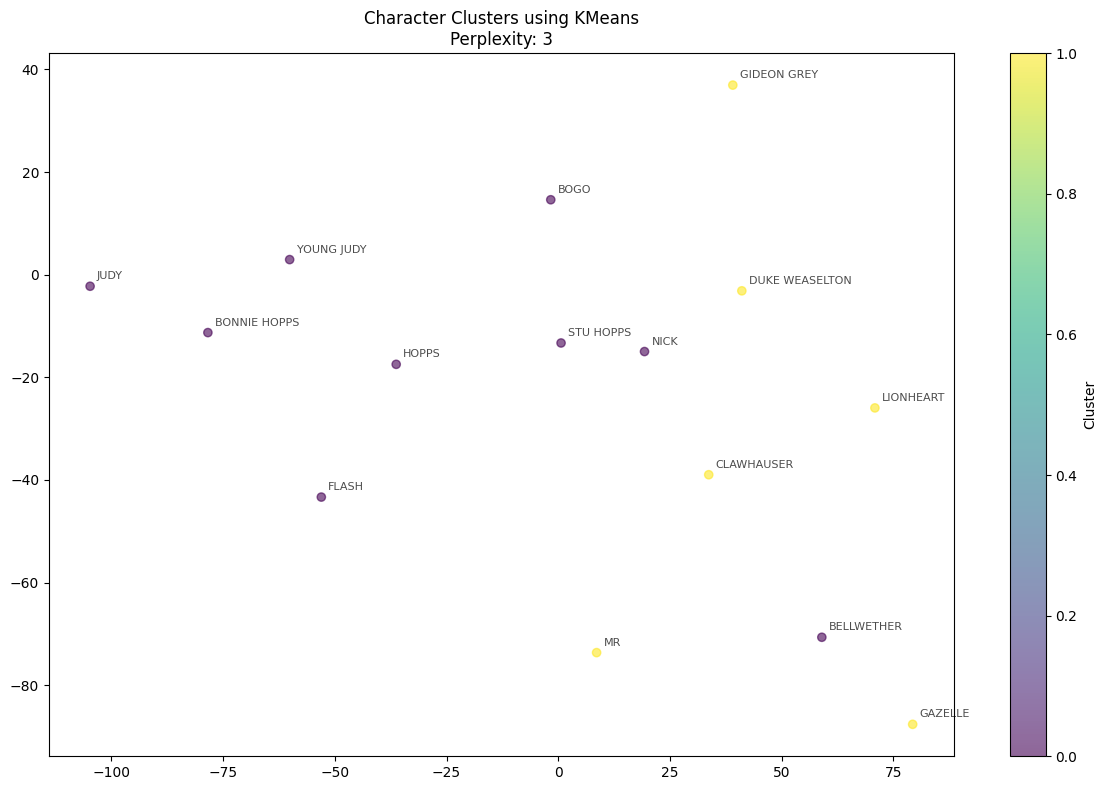


Cluster Statistics:

Cluster 0:
Size: 9
Sample characters: YOUNG JUDY, STU HOPPS, BONNIE HOPPS, BELLWETHER, JUDY

Cluster 1:
Size: 6
Sample characters: GIDEON GREY, LIONHEART, GAZELLE, CLAWHAUSER, DUKE WEASELTON


In [139]:
plot_clusters(embeddings[0], k_means_cluster, embeddings[1], method="KMeans")

/Users/owner/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


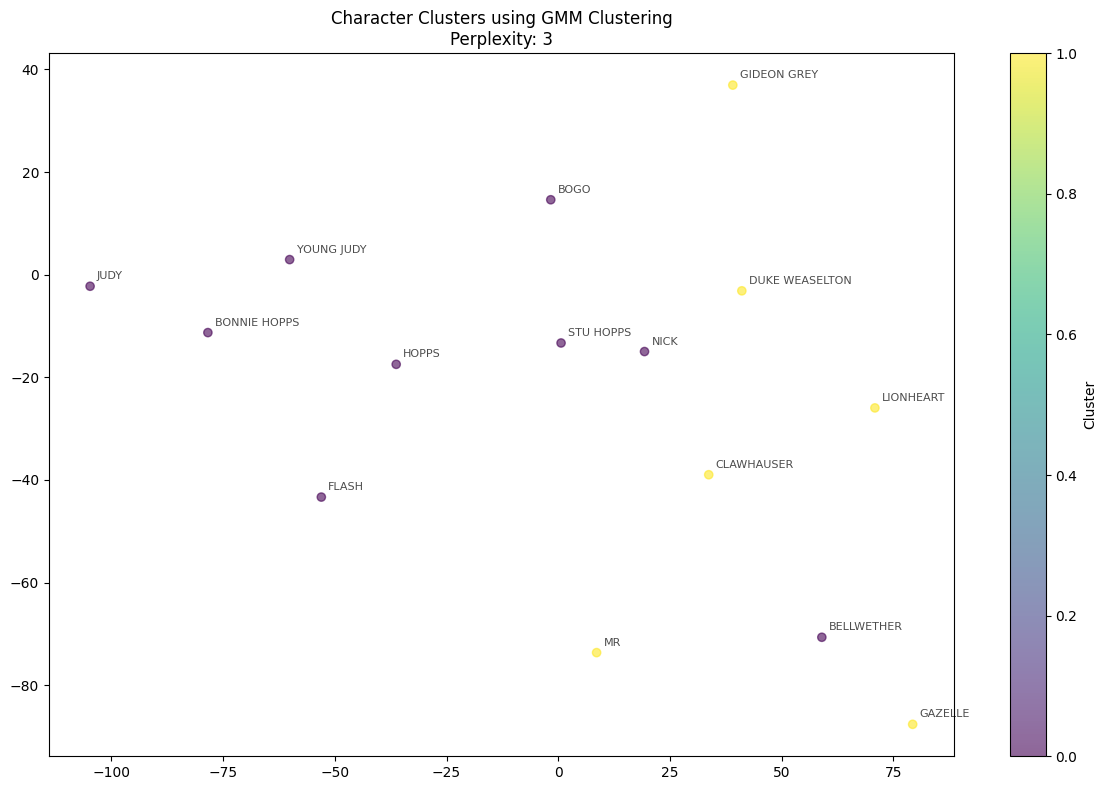


Cluster Statistics:

Cluster 0:
Size: 9
Sample characters: YOUNG JUDY, STU HOPPS, BONNIE HOPPS, BELLWETHER, JUDY

Cluster 1:
Size: 6
Sample characters: GIDEON GREY, LIONHEART, GAZELLE, CLAWHAUSER, DUKE WEASELTON


In [140]:
plot_clusters(embeddings[0], gmm_cluster, embeddings[1], method="GMM Clustering")

##### Task 2

In [141]:
centroids = define_centroids()

character_categories, character_categories_digit = classify_categories(embeddings[0], embeddings[1], centroids)

analyze_categories(character_categories)


Moral Category 3:
Total characters: 3

Example characters:
- YOUNG JUDY from Zootopia
- BELLWETHER from Zootopia
- GAZELLE from Zootopia

Moral Category 4:
Total characters: 1

Example characters:
- DUKE WEASELTON from Zootopia

Moral Category 6:
Total characters: 2

Example characters:
- GIDEON GREY from Zootopia
- MR from Zootopia

Moral Category 7:
Total characters: 2

Example characters:
- JUDY from Zootopia
- BOGO from Zootopia

Moral Category 9:
Total characters: 7

Example characters:
- STU HOPPS from Zootopia
- BONNIE HOPPS from Zootopia
- LIONHEART from Zootopia
- HOPPS from Zootopia
- CLAWHAUSER from Zootopia

Moral Category Counts:
Category 1: 0 characters

Characters by Moral Category:

Moral Category 3:
- YOUNG JUDY from Zootopia
- BELLWETHER from Zootopia
- GAZELLE from Zootopia

Moral Category 4:
- DUKE WEASELTON from Zootopia

Moral Category 6:
- GIDEON GREY from Zootopia
- MR from Zootopia

Moral Category 7:
- JUDY from Zootopia
- BOGO from Zootopia

Moral Category 9:

{1: 0, 2: 0, 3: 3, 4: 1, 5: 0, 6: 2, 7: 2, 8: 0, 9: 7, 10: 0}

In [143]:
print(centroids)

{1: array([-3.27916481e-02, -3.60667646e-01,  2.10328364e+00,  3.35697979e-01,
       -1.03592721e-03,  4.33405370e-01, -1.61449090e-01,  3.33346844e-01,
        2.91017711e-01, -4.06979412e-01, -4.22691137e-01,  3.99007559e-01,
        3.43670338e-01,  5.04793346e-01,  6.05656922e-01,  7.32405186e-02,
       -6.29191160e-01, -3.82700562e-01,  4.52066869e-01, -6.43236816e-01,
       -2.57977754e-01,  8.78623500e-02, -2.88872987e-01, -7.51623034e-01,
       -6.66364729e-01, -5.65171897e-01, -7.39102624e-03, -1.53923082e+00,
       -2.45958388e-01,  1.59290433e-01,  2.61199027e-01,  3.49088386e-02,
        5.79267263e-01, -1.99445993e-01,  1.44598365e-01,  4.77396131e-01,
        2.51032382e-01,  3.08818638e-01, -2.07640678e-01, -1.93535820e-01,
        1.19687641e+00, -1.67985797e-01,  8.57059360e-01,  4.81646121e-01,
       -4.90182340e-01, -4.26002920e-01, -4.32551466e-02,  3.29495430e-01,
       -9.35637672e-03, -9.98385847e-01, -5.51935732e-01, -6.02396429e-01,
        5.24702966e-0

In [125]:
print(character_categories)

[{'movie': np.str_('Cars 2'), 'character': np.str_('FINN'), 'category': 7}, {'movie': np.str_('Cars 2'), 'character': np.str_('PROFESSOR ZUNDAPP'), 'category': 7}, {'movie': np.str_('Cars 2'), 'character': np.str_('GREM'), 'category': 7}, {'movie': np.str_('Cars 2'), 'character': np.str_('ACER'), 'category': 9}, {'movie': np.str_('Cars 2'), 'character': np.str_('MATER'), 'category': 9}, {'movie': np.str_('Cars 2'), 'character': np.str_('OTIS'), 'category': 9}, {'movie': np.str_('Cars 2'), 'character': np.str_('LUIGI'), 'category': 9}, {'movie': np.str_('Cars 2'), 'character': np.str_('MCQUEEN'), 'category': 9}, {'movie': np.str_('Cars 2'), 'character': np.str_('SALLY'), 'category': 3}, {'movie': np.str_('Cars 2'), 'character': np.str_('MEL DORADO'), 'category': 7}, {'movie': np.str_('Cars 2'), 'character': np.str_('MILES AXLEROD'), 'category': 8}, {'movie': np.str_('Cars 2'), 'character': np.str_('FRANCESCO'), 'category': 9}, {'movie': np.str_('Cars 2'), 'character': np.str_('HOLLEY'),

/Users/owner/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


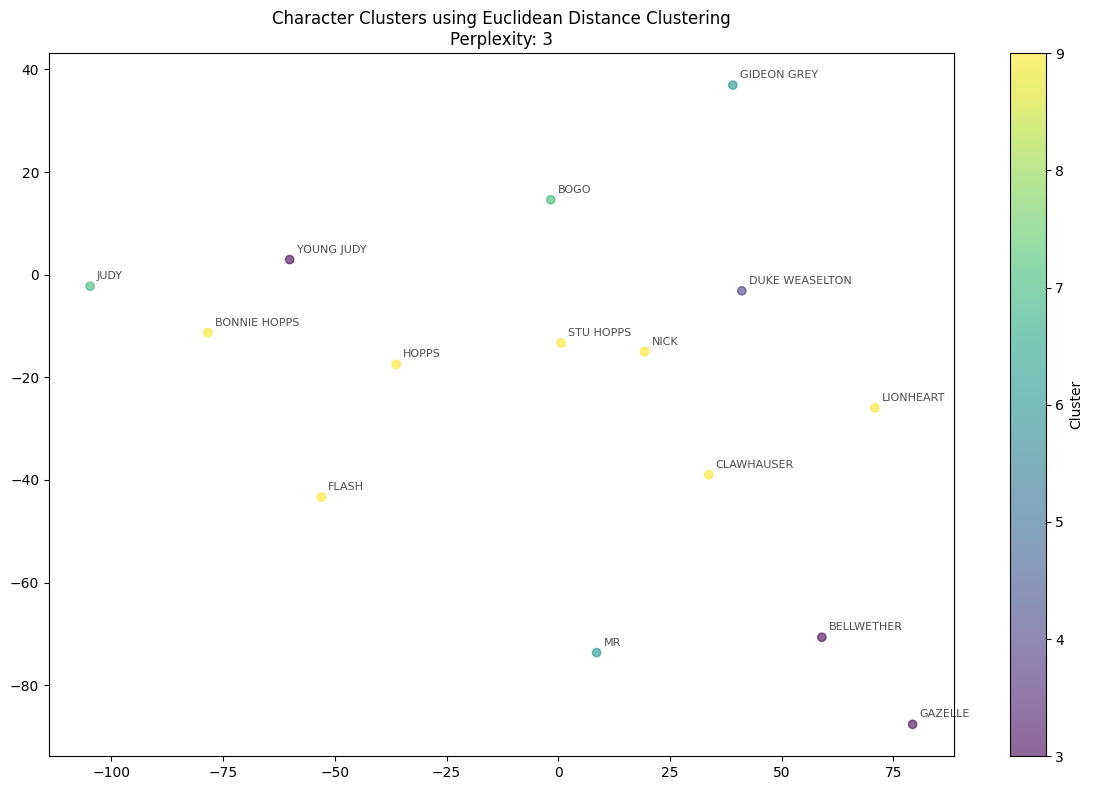


Cluster Statistics:

Cluster 3:
Size: 3
Sample characters: YOUNG JUDY, BELLWETHER, GAZELLE

Cluster 4:
Size: 1
Sample characters: DUKE WEASELTON

Cluster 6:
Size: 2
Sample characters: GIDEON GREY, MR

Cluster 7:
Size: 2
Sample characters: JUDY, BOGO

Cluster 9:
Size: 7
Sample characters: STU HOPPS, BONNIE HOPPS, LIONHEART, HOPPS, CLAWHAUSER


In [142]:
plot_clusters(embeddings[0], character_categories_digit, embeddings[1], method="Euclidean Distance Clustering")

### Part B 

In [62]:
dialogue_with_time = pd.read_csv("../data/movies.csv")

In [66]:
dialogue_with_time.head()

,movie,script,date,genres,first_genre,mfd_count,rank
0,10 Things I Hate About You,\r\n\r\n\r\nTen Things I Hate About You - by K...,1997.0,Comedy_Romance,Comedy,746,Low
1,12,\r\n\r\n \r\n 12 - Script\r\n\r\n\r\n\r\n\r\...,NaN,Comedy,Comedy,635,Low
2,12 and Holding,\r\n \r\n \r\n ...,2004.0,Drama,Drama,805,Low
3,12 Monkeys,\r\n\r\n\r\nTwelve Monkeys\r\n\r\n\r\n\t\t\t\t...,1994.0,Drama_Sci-Fi_Thriller,Drama,1728,High
4,12 Years a Slave,\r\n\r\n\r\n 12 YE...,2013.0,Drama,Drama,1917,High


In [100]:
dialogue_with_time[dialogue_with_time["movie"] == "Cars 2"]["script"].iloc[0]

'                          \r\n                         \r\n                         \r\n                          CARS 2\r\n                         \r\n                         \r\n                          WRITTEN BY\r\n                         \r\n                          BEN QUEEN\r\n                         \r\n                         \r\n                         \r\n          A sleek British sports car talks directly to us in a\r\n          pixilated, garbled video. He\'s OUT OF BREATH. Crates are\r\n          visible behind him. We\'re in the shadowy bowels of a steel\r\n          room.\r\n                         \r\n                          LELAND TURBO\r\n           This is Agent Leland Turbo. I have\r\n           a flash transmission for Agent Finn\r\n           McMissile.\r\n                         \r\n          SUPERIMPOSE OVER BLACK: WALT DISNEY PICTURES PRESENTS\r\n                         \r\n                          LELAND TURBO\r\n           Finn. My cover\'s be

In [ ]:
print(dialogue_with_time[dialogue_with_time["movie"] == "Cars 2"]["script"].iloc[0])

In [102]:
# To ease script checking, we will print the script to a txt file

with open("..//data//cars2_script.txt", "w") as file:
    file.write(dialogue_with_time[dialogue_with_time["movie"] == "Cars 2"]["script"].iloc[0])

Let's try analyze the character development of the main characters along time

Method ideas:
- Split the script into 20 equal parts (the number is tentative)
- Get the speeches from the main characters for each of the 20 parts
- Count each of the moral foundation points for each character on each part
- Plot the how the moral foundations develop over time

We'll continue working on "Cars 2" movie

In [116]:
# Split the script into 20 parts
script = dialogue_with_time[dialogue_with_time["movie"] == "Cars 2"]["script"].iloc[0]
script_lines = script.split('\n')
num_parts = 20
lines_per_part = len(script_lines) // num_parts

script_parts = [script_lines[i * lines_per_part: (i + 1) * lines_per_part] for i in range(num_parts)]

# Join the lines back together for each part
script_parts = ['\n'.join(part) for part in script_parts]

# If there are remaining lines, add them to the last part
if len(script.split('\n')) % num_parts != 0:
    script_parts[-1] += '\n' + '\n'.join(script.split('\n')[num_parts * lines_per_part:])


In [117]:
for i in range(len(script_parts)):
    print(f'Part {i} : {len(script_parts[i])} characters')  # Print the number of characters in each part

Part 0 : 15055 characters
Part 1 : 13412 characters
Part 2 : 13839 characters
Part 3 : 13843 characters
Part 4 : 13921 characters
Part 5 : 13600 characters
Part 6 : 13953 characters
Part 7 : 14222 characters
Part 8 : 14300 characters
Part 9 : 13676 characters
Part 10 : 14069 characters
Part 11 : 13945 characters
Part 12 : 13596 characters
Part 13 : 13792 characters
Part 14 : 14366 characters
Part 15 : 13319 characters
Part 16 : 13966 characters
Part 17 : 14224 characters
Part 18 : 13668 characters
Part 19 : 13623 characters


Judging by the number of characters distribution, the script is roughly equally divided.

But we need to double check it manually to make sure it does not split the script in the middle of a dialogue. In order to do this, we need to adjust them manually.

In [119]:
# Print each part to a separate text file
for i, part in enumerate(script_parts):
    with open(f'../data/cars2/cars2_script_part_{i}.txt', 'w') as file:
        file.write(part)

In [121]:
# Now we load back the script parts

script_parts = []
for i in range(num_parts):
    with open(f'../data/cars2/cars2_script_part_{i}.txt', 'r') as file:
        script_parts.append(file.read())